In [15]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import crocosi.postp as pp
import dask.dataframe as dd
import pandas as pd

import hvplot.pandas
import hvplot.dask
import pandas as pd
from glob import glob
import xarray as xr

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:49266 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## Fonctions interpolations des grilles de vitesses à celles de rho

In [12]:
#from u grid to rho grid:

def u2rho(var_u,intert):


    if var_u.ndim<3:
        var_rho = u2rho_2d(var_u,intert)
    else:
        var_rho = u2rho_3d(var_u,intert)

    return var_rho


def u2rho_2d(var_u,intert):
    [Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=xr.Dataset({'u': (['y_rho','x_rho'],np.zeros((Mp,Lp)))},coords={'y_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['x_rho'].values})

#r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,1:L]=0.5*(var_u[:,0:Lm]+var_u[:,1:L])
    var_rho.u[:,0]=var_rho.u[:,1]
    var_rho.u[:,Lp-1]=var_rho.u[:,L-1]
    return var_rho


def u2rho_3d(var_u,intert):
    var_u = var_u.sel(time=slice(intert[0],intert[1]))
    [N,Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=xr.Dataset({'u': (['time','y_rho','x_rho'],np.zeros((N,Mp,Lp)))},coords={'time' : r['surf'].ssh.sel(time=slice(intert[0],intert[1])).coords['time'].values,
                                                                              'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.coords['x_rho'].values})

    #r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,:,1:L]=0.5*(var_u[:,:,0:Lm]+var_u[:,:,1:L])
    var_rho.u[:,:,0]=var_rho.u[:,:,1]
    var_rho.u[:,:,Lp-1]=var_rho.u[:,:,L-1]
    return var_rho

#######################################################

#From v grid to rho grid:

def v2rho(var_v,intert):

    if var_v.ndim<3:
        var_rho = v2rho_2d(var_v,intert)
    else:
        var_rho = v2rho_3d(var_v,intert)

    return var_rho


def v2rho_2d(var_v,intert):
    [M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=xr.Dataset({'v': (['y_rho','x_rho'],np.zeros((Mp,Lp)))},coords={'y_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['x_rho'].values})

    var_rho.v[1:M,:]=0.5*(var_v[0:Mm,:]+var_v[1:M,:])
    var_rho.v[0,:]=var_rho.v[1,:]
    var_rho.v[Mp-1,:]=var_rho.v[M-1,:]
    return var_rho



def v2rho_3d(var_v):
    var_v = var_v.sel(time=slice(intert[0],intert[1]))
    [N,M,Lp]=var_v.shape
    Mp=M+1
    Mm=M-1
    var_rho=xr.Dataset({'v': (['y_rho','x_rho'],np.zeros((N,Mp,Lp)))},coords={'time' : r['surf'].ssh.coords['time'].values,
                                                                              'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                            'x_rho' : r['surf'].ssh.coords['x_rho'].values})

    var_rho.v[:,1:M,:]=0.5*(var_v[:,0:Mm,:]+var_v[:,1:M,:])
    var_rho.v[:,0,:]=var_rho.v[:,1,:]
    var_rho.v[:,Mp-1,:]=var_rho.v[:,M-1,:]

    return var_rho



In [4]:
root_path = '/Users/zcaspar/'
#run = 'jet_cfg1_wp9_4km_0a2000j/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
#file='t1/file_his_00010101-00010125.nc'
#File='t1'
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], grid_params=gparams)

In [5]:
path_data='/Users/zcaspar/jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
df = dd.read_csv(glob(path_data+'t1/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                 delim_whitespace=True).persist()

## 1 drifter :

### Paramètres :

In [91]:
Dt = 48*6
ti = 1500
tf = 1506
vari1 = 'u'
vari2 = 'v'
floats_var = 'depth'
float_id = 4000 

In [7]:
float = df.groupby('id').get_group(float_id).compute().sort_values('time').set_index('time')

In [8]:
float30 = df.groupby('id').get_group(30).compute().sort_values('time').set_index('time')

In [9]:
float300 = df.groupby('id').get_group(300).compute().sort_values('time').set_index('time')

In [22]:
np.rank(r['surf'][vari1])

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  """Entry point for launching an IPython kernel.


4

### 1 variable de fond

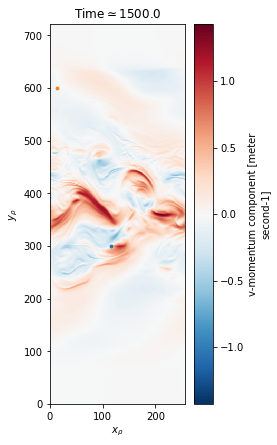

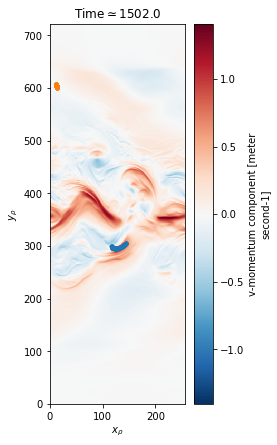

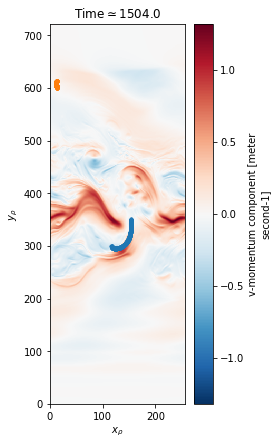

In [94]:
plt.ion()
n = 0
for t in float.loc[ti:tf:Dt].index:
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1,2,1)
    r['surf'][vari1].sel(time=t,method='nearest').plot(ax=ax,label=None)
    cs = ax.scatter(float.loc[ti:t].xgrid,float.loc[ti:t].ygrid,s=8)
    ax.scatter(float300.loc[ti:t].xgrid,float300.loc[ti:t].ygrid,s=8)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
#    fig.savefig('../Figures/Fig%s.png'%n)
    #plt.close()
    n += 1
    plt.show()

### 2 variables de fond différentes :

In [25]:
plt.ioff()
n = 0
for t in float.loc[ti:tf:Dt].index:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    r['surf'][vari1].sel(time=t,method='nearest').plot(ax=ax,label=None)
    ax.scatter(float.loc[ti:t].xgrid,float.loc[ti:t].ygrid,s=8)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    ax1 = fig.add_subplot(1,2,2)
    r['surf'][vari2].sel(time=t,method='nearest').plot(ax=ax1)
    ax1.scatter(float.loc[ti:t].xgrid,float.loc[ti:t].ygrid,s=8)
    ax1.set_aspect('equal')
    ax1.set_ylabel(r'$y_{\rho}$')
    ax1.set_xlabel(r'$x_{\rho}$')
    ax1.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    fig.tight_layout()
    fig.savefig('../Figures/Fig%s.png'%n)
    plt.close()
    n += 1

### Couleurs=variables drifter :

In [23]:
plt.ioff()
n = 0
vmin = float.loc[ti:tf][floats_var].min()
vmax = float.loc[ti:tf][floats_var].max()
#float_U = np.sqrt(float.loc[ti:t].X1**2+float.loc[ti:t].X2**2)
for t in float.loc[ti:tf:Dt].index:
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,2,1)
    r['surf'][vari1].sel(time=t,method='nearest').plot(ax=ax,label=None)
    cs = ax.scatter(float.loc[ti:t].xgrid,float.loc[ti:t].ygrid,s=8,c=float.loc[ti:t][floats_var])
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    cbar_ax = fig.add_axes([0.01, 0.05, 0.6, 0.03])
    fig.colorbar(cs, cax=cbar_ax, orientation ='horizontal',label='SSH (meters)')
 #   fig.tight_layout()
    fig.savefig('../Figures/Fig%s.png'%n)
    plt.close()
    n += 1

In [7]:

plt.ioff()
n = 0
vmin = float30.loc[ti:tf][floats_var].min()
vmax = float30.loc[ti:tf][floats_var].max()
for t in float30.loc[ti:tf:Dt].index:
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,2,1)
    r['surf'][vari1].sel(time=t,method='nearest').plot(ax=ax,label=None)
    cs = ax.scatter(float30.loc[ti:t].xgrid,float30.loc[ti:t].ygrid,s=8,c=float30.loc[ti:t][floats_var],vmin=vmin,vmax=vmax)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    ax1 = fig.add_subplot(1,2,2)
    r['surf'][vari2].sel(time=t,method='nearest').plot(ax=ax1,label=None)
    cs1 = ax1.scatter(float30.loc[ti:t].xgrid,float30.loc[ti:t].ygrid,s=8,c=float30.loc[ti:t].depth,vmax=vmax,vmin=vmin)
    ax1.set_aspect('equal')
#    ax1.set_ylabel(r'$y_{\rho}$')
    ax1.set_xlabel(r'$x_{\rho}$')
    ax1.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    #fig.colorbar(cs1,shrink = 0.5,orientation="horizontal")
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.03])
#    fig.subplots_adjust(wspace=0.3)
    fig.colorbar(cs, cax=cbar_ax, orientation ='horizontal',label='SSH')
#    fig.tight_layout()
    
    fig.savefig('../Figures/Fig%s.png'%n)
    plt.close()
    n += 1

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


In [89]:
#Décale  dans le temps :
#Dt=6
plt.ioff()
n = 0
vmin = float300.loc[ti:tf][floats_var].min()
vmax = float300.loc[ti:tf][floats_var].max()
#v1 = (r['surf'][vari1].shift(time=-1)+r['surf'][vari1])*.5
for t in float300.loc[ti:tf:Dt].index:
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,2,1)
    #r_var = 0.5*(r['surf'][vari1].sel(time=t,method='pad')+r['surf'][vari1].sel(time=t,method='backfill'))
    r_var = v1.sel(time=t, method='pad')
    r_var.plot(ax=ax,label=None)
    cs = ax.scatter(float300.loc[ti:t].xgrid,float300.loc[ti:t].ygrid,s=8,c=float300.loc[ti:t][floats_var],vmin=vmin,vmax=vmax)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    ax1 = fig.add_subplot(1,2,2)
    #r_var2 = 0.5*(r['surf'][vari2].sel(time=t,method='pad')+r['surf'][vari2].sel(time=t,method='backfill'))
    r_var2 = v2.sel(time=t, method='pad')
    r_var2.plot(ax=ax1,label=None)
    cs1 = ax1.scatter(float300.loc[ti:t].xgrid,float300.loc[ti:t].ygrid,s=8,c=float300.loc[ti:t].depth,vmax=vmax,vmin=vmin)
    ax1.set_aspect('equal')
#    ax1.set_ylabel(r'$y_{\rho}$')
    ax1.set_xlabel(r'$x_{\rho}$')
    ax1.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    #fig.colorbar(cs1,shrink = 0.5,orientation="horizontal")
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.03])
#    fig.subplots_adjust(wspace=0.3)
    fig.colorbar(cs, cax=cbar_ax, orientation ='horizontal',label='SSH')
#    fig.tight_layout()
    
    fig.savefig('../Figures/Fig%s.png'%n)
    plt.close()
    n += 1

In [28]:
#En interpolant vitesses sur grille rho
#(pas utile de toute façon les drifter n'ont pas de coord qui tomebent sur les rho coords): 
plt.ioff()
n = 0
vmin = float30.loc[ti:tf][floats_var].min()
vmax = float30.loc[ti:tf][floats_var].max()
for t in float30.loc[ti:tf:Dt].index:
    var_u = u2rho(r['surf']['u'][:,0,:,:].sel(time=t,method='nearest'),t)
    var_v = v2rho(r['surf']['v'][:,0,:,:].sel(time=t,method='nearest'),t)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,2,1)
    var_u.u.plot(ax=ax,label=None)
    cs = ax.scatter(float30.loc[ti:t].xgrid,float30.loc[ti:t].ygrid,s=8,c=float30.loc[ti:t][floats_var],vmin=vmin,vmax=vmax)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    ax1 = fig.add_subplot(1,2,2)
    var_v.v.plot(ax=ax1,label=None)
    cs1 = ax1.scatter(float30.loc[ti:t].xgrid,float30.loc[ti:t].ygrid,s=8,c=float30.loc[ti:t].depth,vmax=vmax,vmin=vmin)
    ax1.set_aspect('equal')
#    ax1.set_ylabel(r'$y_{\rho}$')
    ax1.set_xlabel(r'$x_{\rho}$')
    ax1.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    #fig.colorbar(cs1,shrink = 0.5,orientation="horizontal")
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.03])
#    fig.subplots_adjust(wspace=0.3)
    fig.colorbar(cs, cax=cbar_ax, orientation ='horizontal',label='SSH')
#    fig.tight_layout()
    
    fig.savefig('../Figures/Fig%s.png'%n)
    plt.close()
    n += 1

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


## Plusieurs drifters : 

In [107]:
Dt = 48*6*2 # 2 fois le même temps à cause de la concatenation (trouver un moins plus rapide /efficace)
ti = 1500
tf = 1600
vari1 = 'u'
vari2 = 'v'
float_id = [102,2000] 

In [69]:
floats = pd.concat([df.groupby('id').get_group(group).compute() for i, group in enumerate(float_id)])
floats = floats.sort_values('time').set_index('time')

In [106]:
plt.ioff()
n = 0
for t in floats.loc[ti:tf:Dt].index:
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1,2,1)
    r['surf'][vari1].sel(time=t,method='nearest').plot(ax=ax,label=None)
    cs = ax.scatter(floats.loc[ti:t].xgrid,floats.loc[ti:t].ygrid,s=8)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    fig.savefig('../Figures/Fig%s.png'%n)
    plt.close()
    n += 1

In [108]:
Dt = 24*6
n = 0
vmin = floats.loc[ti:tf].depth.min()
vmax = floats.loc[ti:tf].depth.max()
for t in floats.loc[ti:tf:Dt].index:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    r['surf'][vari1].sel(time=t,method='nearest').plot(ax=ax,label=None)
    ax.scatter(float30.loc[ti:t].xgrid,float30.loc[ti:t].ygrid,s=8,c=floats.loc[ti:t][floats_var],vmin=vmin,vmax=vmax)
    ax.set_aspect('equal')
    ax.set_ylabel(r'$y_{\rho}$')
    ax.set_xlabel(r'$x_{\rho}$')
    ax.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    ax1 = fig.add_subplot(1,2,2)
    r['surf'][vari2].sel(time=t,method='nearest').plot(ax=ax1,label=None)
    ax1.scatter(float30.loc[ti:t].xgrid,float30.loc[ti:t].ygrid,s=8,c=float30.loc[ti:t][floats_var],vmin=vmin,vmax=vmax)
    ax1.set_aspect('equal')
    ax1.set_ylabel(r'$y_{\rho}$')
    ax1.set_xlabel(r'$x_{\rho}$')
    ax1.set_title(r'Time$\simeq$%s'%np.around(t,decimals=1))
    cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.05])
#    fig.subplots_adjust(wspace=0.3)
    fig.colorbar(cs, cax=cbar_ax, orientation ='horizontal',label='SSH')
#    fig.tight_layout()
    fig.savefig('../Figures/Fig%s.png'%n)
    plt.close()
    n += 1

In [102]:
floats.index

Float64Index([1500.0069, 1500.0069, 1500.0139, 1500.0139, 1500.0208, 1500.0208,
              1500.0278, 1500.0278, 1500.0347, 1500.0347,
              ...
              1599.9722, 1599.9722, 1599.9792, 1599.9792, 1599.9861, 1599.9861,
              1599.9931, 1599.9931,    1600.0,    1600.0],
             dtype='float64', name='time', length=28800)

### tests

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


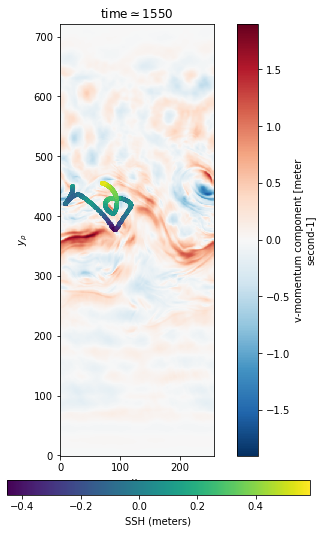

In [41]:
plt.ion()
vmin = float.loc[1500:1550].depth.min()
vmax = float.loc[1500:1550].depth.max()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
r['surf'].u.sel(time=1550,method='nearest').plot(ax=ax,label=None)
cs = ax.scatter(float500.loc[1500:1550].xgrid,float500.loc[1500:1550].ygrid,s=8,c=float.loc[1500:1550].depth,vmin=vmin,vmax=vmax)
ax.set_aspect('equal')
ax.set_ylabel(r'$y_{\rho}$')
ax.set_xlabel(r'$x_{\rho}$')
ax.set_title(r'time$\simeq$%s'%1550)
cbar_ax = fig.add_axes([0.35, 0.01, 0.6, 0.03])
fig.colorbar(cs, cax=cbar_ax, orientation ='horizontal',label='SSH (meters)')
fig.tight_layout()

In [12]:
[N,Mp,L] = r['surf'].u[:,0,:,:].shape

In [14]:
var = r['surf'].u[:,0,:,:]

In [15]:
0.5*(var[:,:,0:L-1]+var[:,:,1:L])

<xarray.DataArray 'u' (time: 14400, y_rho: 722, x_u: 256)>
dask.array<mul, shape=(14400, 722, 256), dtype=float32, chunksize=(1, 722, 256), chunktype=numpy.ndarray>
Coordinates:
    eta_u         (y_rho, x_u) float32 -2000.0 -2000.0 ... 2882000.0 2882000.0
    s_rho_slice0  float32 -0.01
    time_instant  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
Dimensions without coordinates: y_rho, x_u

In [21]:
test = r['surf'].ssh.copy()

In [ ]:
test[:,:,1:L] = 0.5*(var[:,:,0:L-1]+var[:,:,1:L]).values

In [16]:
test1 = u2rho(r['surf'].u[:,0,:,:].sel(time=1550,method='nearest'),1550)

In [20]:
testv = v2rho(r['surf'].v[:,0,:,:].sel(time=1550,method='nearest'),1550)

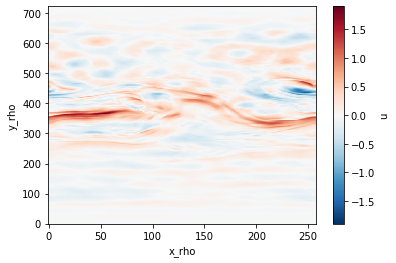

In [19]:
test1.u.plot()

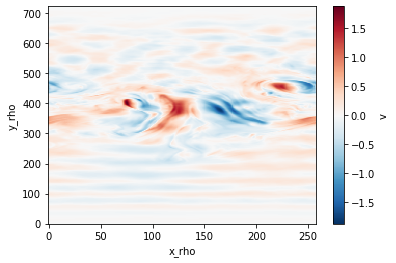

In [21]:
testv.v.plot()

In [23]:
U = np.sqrt(testv.v**2+test1.u**2)

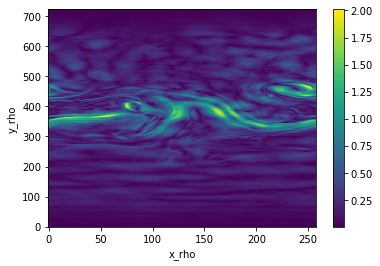

In [25]:
U.plot()

In [114]:
# test traj. + velocity

In [129]:
def plot_zoomfloat(floati,var,Deltat,var_bckgd):
    varx = floati.xgrid.loc[Deltat[0]:Deltat[1]]
    vary = floati.ygrid.loc[Deltat[0]:Deltat[1]]
    varu = floati[var].loc[Deltat[0]:Deltat[1]]
    [xmin,xmax,ymin,ymax] = [np.int(varx.min()),np.int(varx.max()),np.int(vary.min()),np.int(vary.max())]
    print(xmin,xmax,ymin,ymax)
    Bckgd = r['surf'][var_bckgd].sel(time=slice(Deltat[0],Deltat[1]),x_rho=slice(xmin,xmax),y_rho=slice(ymin,ymax))
    for t in varu.index:
        fig = plt.figure()
        ax = fig.add_subplot(1,2,1)
        ax1 = fig.add_subplot(1,2,2)
        Bckgd.sel(time=t,method='nearest').plot(ax=ax)
        ax.plot(varx,vary)
        ax1.plot(varu.index,varu)
    return Bckgd

49 52 579 583


<xarray.DataArray 'ssh' (time: 144, y_rho: 4, x_rho: 3)>
dask.array<getitem, shape=(144, 4, 3), dtype=float32, chunksize=(1, 4, 3), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(4, 3), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(4, 3), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time          (time) float64 1.52e+03 1.52e+03 ... 1.521e+03 1.521e+03
    f             (y_rho, x_rho) float32 dask.array<chunksize=(4, 3), meta=np.ndarray>
Dimensions without coordinates: y_rho, x_rho
Attributes:
    long_name:           free-surface
    units:               meter
    online_operation:    instant
    interval_operation:  300 s
    interval_write:      600 s
    cell_methods:        time: point (interval: 300 s)

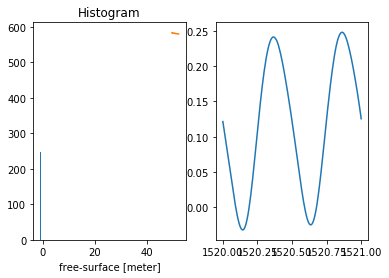

In [131]:
plot_zoomfloat(float300,'X1',[1520,1521],'ssh')

In [122]:
float300['X1']

time
1500.0069   -0.048800
1500.0139   -0.048690
1500.0208   -0.048579
1500.0278   -0.048468
1500.0347   -0.048357
               ...   
1599.9722   -0.097048
1599.9792   -0.086462
1599.9861   -0.075373
1599.9931   -0.063909
1600.0000   -0.052165
Name: X1, Length: 14400, dtype: float64

In [127]:
np.int(49.5)

49

In [ ]:
def interpt(var,intert):
    if var_t.ndim<3:
        var_t = u2rho_2d(var,intert)
    else:
        var_t = u2rho_3d(var,intert)

    return var_t


def u2rho_2d(var_u,intert):
    [Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=xr.Dataset({'u': (['y_rho','x_rho'],np.zeros((Mp,Lp)))},coords={'y_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['x_rho'].values})

#r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,1:L]=0.5*(var_u[:,0:Lm]+var_u[:,1:L])
    var_rho.u[:,0]=var_rho.u[:,1]
    var_rho.u[:,Lp-1]=var_rho.u[:,L-1]
    return var_rho


def u2rho_3d(var_u,intert):
    var_u = var_u.sel(time=slice(intert[0],intert[1]))
    [N,Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    var_rho=xr.Dataset({'u': (['time','y_rho','x_rho'],np.zeros((N,Mp,Lp)))},coords={'time' : r['surf'].ssh.sel(time=slice(intert[0],intert[1])).coords['time'].values,
                                                                              'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.coords['x_rho'].values})

    #r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,:,1:L]=0.5*(var_u[:,:,0:Lm]+var_u[:,:,1:L])
    var_rho.u[:,:,0]=var_rho.u[:,:,1]
    var_rho.u[:,:,Lp-1]=var_rho.u[:,:,L-1]
    return var_rho
    

1

'flt0'